In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import json
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Dropout, Conv1D, MaxPooling1D, Flatten, MaxPooling2D, Conv2D
from keras import regularizers, activations
import matplotlib.pyplot as plt
from sklearn.metrics import label_ranking_average_precision_score

In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
encoder = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [3]:
genreToIndex = {
    "Drama": 0,
    "Comedy": 1,
    "Thriller": 2,
    "Action": 3,
    "Romance": 4,
    "Adventure": 5,
    "Crime": 6,
    "Science Fiction": 7,
    "Horror": 8,
    "Family": 9,
    "Fantasy": 10,
    "Mystery": 11,
    "Animation": 12,
    "History": 13,
    "Music": 14,
    "War": 15,
    "Documentary": 16,
    "Western": 17,
    "Foreign": 18,
    "TV Movie": 19
}

indexToGenre = [
    "Drama",
    "Comedy",
    "Thriller",
    "Action",
    "Romance",
    "Adventure",
    "Crime",
    "Science Fiction",
    "Horror",
    "Family",
    "Fantasy",
    "Mystery",
    "Animation",
    "History",
    "Music",
    "War",
    "Documentary",
    "Western",
    "Foreign",
    "TV Movie"
]

In [4]:
csv_path = '/content/drive/MyDrive/EDA/Project/data/tmdb.csv'

In [5]:
df = pd.read_csv(csv_path)
df.head(3)

,Unnamed: 0,budget,genres,homepage,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [6]:
def one_hot_encode_genres(df):
  labels = []
  for genres in df["genres"]:
    genreList = json.loads(genres)
    label = [0 for _ in range(len(indexToGenre))]
    for genre in genreList:
      genreName = genre["name"]
      genreIndex = genreToIndex[genreName]
      label[genreIndex] = 1
    labels.append(label)
  return labels

In [7]:
def get_overviews(df):
  overviews = df["overview"].fillna("")
  return list(overviews)

In [8]:
def get_titles(df):
  titles = df["title"].fillna("")
  return list(titles)

In [9]:
def get_taglines(df):
  taglines = df["tagline"].fillna("")
  return list(taglines)

In [10]:
def get_keywords_concat(df):
  keywordsAll = []
  for keywordsJson in df["keywords"]:
    keywordsList = json.loads(keywordsJson)
    keywords = []
    for keyword in keywordsList:
      keywordName = keyword["name"]
      keywords.append(keywordName)
    keywordsAll.append(" ".join(keywords))
  return keywordsAll

In [11]:
def get_dataframe(data_list, column_list):
  assert len(data_list) == len(column_list)

  newDf = pd.DataFrame()
  for i in range(len(data_list)):
    column = column_list[i]
    data = data_list[i]
    newDf[column] = data
    
  return newDf

In [12]:
overviews = get_overviews(df)
taglines = get_taglines(df)
titles = get_titles(df)
keywords = get_keywords_concat(df)


In [14]:
overviews_enc = np.array(encoder(overviews))
taglines_enc = np.array(encoder(taglines))
titles_enc = np.array(encoder(titles))
keywords_enc = np.array(encoder(keywords))
print(overviews_enc.shape)
print(taglines_enc.shape)
print(titles_enc.shape)
print(keywords_enc.shape)

(4803, 512)
(4803, 512)
(4803, 512)
(4803, 512)


In [15]:
def concat_features_cnn(features):
  features_with_channel = [np.reshape(feature, newshape=(feature.shape[0], -1, 1)) for feature in features]
  return np.concatenate(features_with_channel, axis=-1)

In [16]:
features = concat_features_cnn(
    [
     overviews_enc,
     taglines_enc,
     titles_enc,
     keywords_enc
    ]
)
print(features.shape)

(4803, 512, 4)


In [17]:
labels = np.array(one_hot_encode_genres(df))
print(labels.shape)

(4803, 20)


In [18]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=6)
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(3842, 512, 4)
(961, 512, 4)
(3842, 20)
(961, 20)


In [52]:
def create_cnn(n_genres=20):
  cnn = Sequential([
      Conv1D(filters=32, kernel_size=4, strides=2, padding='valid'),
      BatchNormalization(),
      Activation('relu'),

      Conv1D(filters=64, kernel_size=4, strides=2, padding='valid'),
      BatchNormalization(),
      Activation('relu'),

      Conv1D(filters=128, kernel_size=4, strides=2, padding='valid'),
      BatchNormalization(),
      Activation('relu'),

      Conv1D(filters=256, kernel_size=4, strides=2, padding='valid'),
      BatchNormalization(),
      Activation('relu'),

      Flatten(),

      Dense(128),
      BatchNormalization(),
      Activation('relu'),
      Dropout(0.3),

      Dense(128),
      BatchNormalization(),
      Activation('relu'),
      Dropout(0.3),

      Dense(n_genres),
      Activation('sigmoid')
  ])
  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  cnn.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy())
  return cnn

In [53]:
def train_cnn(cnn, epochs, train_features, train_labels, val_features, val_labels):
  history = cnn.fit(x=train_features, y=train_labels, batch_size=64, epochs=epochs, validation_data=(val_features, val_labels), verbose=2, shuffle=True)
  return history

In [54]:
cnn = create_cnn()

In [55]:
history = train_cnn(cnn, 20, train_features, train_labels, test_features, test_labels)

Epoch 1/20
61/61 - 6s - loss: 0.2751 - val_loss: 0.2972 - 6s/epoch - 97ms/step
Epoch 2/20
61/61 - 1s - loss: 0.2090 - val_loss: 0.2395 - 917ms/epoch - 15ms/step
Epoch 3/20
61/61 - 1s - loss: 0.1832 - val_loss: 0.2951 - 977ms/epoch - 16ms/step
Epoch 4/20
61/61 - 1s - loss: 0.1680 - val_loss: 0.2966 - 907ms/epoch - 15ms/step
Epoch 5/20
61/61 - 1s - loss: 0.1953 - val_loss: 0.1982 - 983ms/epoch - 16ms/step
Epoch 6/20
61/61 - 1s - loss: 0.1641 - val_loss: 0.2287 - 919ms/epoch - 15ms/step
Epoch 7/20
61/61 - 1s - loss: 0.1413 - val_loss: 0.2406 - 913ms/epoch - 15ms/step
Epoch 8/20
61/61 - 1s - loss: 0.1323 - val_loss: 0.2271 - 908ms/epoch - 15ms/step
Epoch 9/20
61/61 - 1s - loss: 0.1207 - val_loss: 0.2352 - 905ms/epoch - 15ms/step
Epoch 10/20
61/61 - 1s - loss: 0.1218 - val_loss: 0.2290 - 899ms/epoch - 15ms/step
Epoch 11/20
61/61 - 1s - loss: 0.1066 - val_loss: 0.2431 - 983ms/epoch - 16ms/step
Epoch 12/20
61/61 - 1s - loss: 0.1204 - val_loss: 0.2567 - 917ms/epoch - 15ms/step
Epoch 13/20
61/6

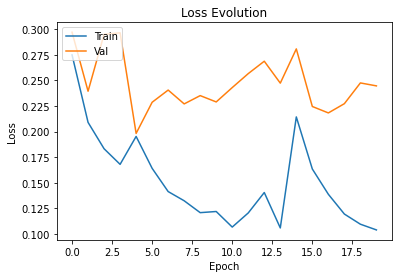

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [59]:
test_preds = cnn.predict(test_features)

In [60]:
print(label_ranking_average_precision_score(y_true=test_labels, y_score=test_preds))

0.781255737789502


In [61]:
test_preds_rounded = np.rint(test_preds)
test_preds_rounded = test_preds_rounded.astype('i')
for i in range(0, 20):
  print(test_labels[i])
  print(test_preds_rounded[i])
  print()

[0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]

[1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]

[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 